![](http://pic1.tsingdataedu.com/%E9%87%8F%E5%8C%96banner.jpg)

# 【实战】优化版的成对交易模型
#### [稀牛学院 x 网易云课程]《AI量化交易》 by @加号 

### Moving Average

既然是滚动平均值，那我们就需要一个滚动的OLS来计算每一次：

In [298]:
from pyfinance.ols import PandasRollingOLS
rolling_beta = PandasRollingOLS(y=S1, x=S2, window=30)
print(rolling_beta.beta.head())

            feature1
2016-04-12 -0.119287
2016-04-13 -0.063562
2016-04-14  0.018802
2016-04-15  0.094118
2016-04-18  0.151175


然后，我们用这个滚动的OLS，去计算滚动的平均值：

In [299]:

spread = S2 - rolling_beta.beta['feature1'] * S1
spread.name = 'spread'

# 画出每一天的MAVG
spread_mavg1 = spread.rolling(window=1).mean()
spread_mavg1.name = 'spread 1d mavg'

# 画出每30天的MAVG
spread_mavg30 = spread.rolling(window=30).mean()
spread_mavg30.name = 'spread 30d mavg'

plt.plot(spread_mavg1.index, spread_mavg1.values)
plt.plot(spread_mavg30.index, spread_mavg30.values)

plt.legend(['1 Day Spread MAVG', '30 Day Spread MAVG'])

plt.ylabel('Spread');

大家看到，楼上的滚动平均值更加的平滑，并且我们更准确清晰地知道什么时候我们要采取什么策略。

相比于单独的一个全局平均值，滚动平均值会随着市场的变化而变化，更加符合我们曲线的走势。

既然我们有了1天和30天的spread，我们就可以把这两个值当作我们的x和y，并用他们计算出一个统一的standard score，

面对这个zscore，我们可以更加直观的看出来我们的股票价格在什么时间点处于“极端值”：

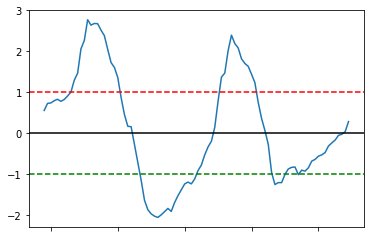

In [311]:
# Take a rolling 30 day standard deviation
std_30 = spread.rolling(window=30).std()
std_30.name = 'std 30d'

# Compute the z score for each day
zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30
zscore_30_1.name = 'z-score'
zscore_30_1.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--');

好，为了更加清晰地给大家看看我们这个走势变化与真实股票的关系，

我们可以把三个线 都画在同一个坐标系内：

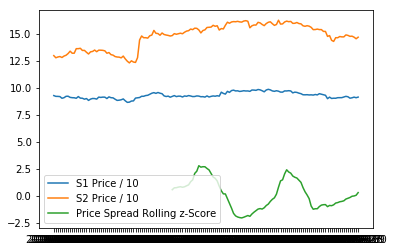

In [301]:
# Plot the prices scaled down along with the negative z-score
# just divide the stock prices by 10 to make viewing it on the plot easier
plt.plot(S1.index, S1.values/10)
plt.plot(S2.index, S2.values/10)
plt.plot(zscore_30_1.index, zscore_30_1.values)
plt.legend(['S1 Price / 10', 'S2 Price / 10', 'Price Spread Rolling z-Score']);

### Out of Sample

如果我们的目标数据在我们考察的时间段范围以外怎么办？这样我们就需要再做一次Coint测试

比如，我们拿出一个S1与S2在新的时间段中的数据比较：

In [303]:
data_KDP = pd.read_csv('./data/daily_KDP.csv', index_col=[0],usecols=['timestamp','close'])
data_KDP.columns = ["KDP"]
data_MNST = pd.read_csv('./data/daily_MNST.csv', index_col=[0],usecols=['timestamp','close'])
data_MNST.columns = ["MNST"]
data = pd.concat([data_KDP, data_MNST,],axis=1,)
data = data['2018-03-01':'2018-10-01']
data.fillna(method='ffill')

KDP   MNST
2018-03-01  116.44  54.22
2018-03-02  116.24  54.16
2018-03-05  115.91  55.74
2018-03-06  116.12  55.67
2018-03-07  116.30  55.55
2018-03-08  117.35  56.83
2018-03-09  117.95  58.06
2018-03-12  117.59  58.43
2018-03-13  117.65  58.69
2018-03-14  117.81  58.73
2018-03-15  117.27  58.19
2018-03-16  117.60  58.64
2018-03-19  118.36  58.27
2018-03-20  118.40  58.68
2018-03-21  118.00  58.08
2018-03-22  118.02  56.78
2018-03-23  117.95  55.86
2018-03-26  118.42  56.87
2018-03-27  118.28  56.25
2018-03-28  118.36  56.24
2018-03-29  118.38  57.21
2018-04-02  118.10  55.62
2018-04-03  118.19  55.73
2018-04-04  118.42  56.77
2018-04-05  118.65  57.41
2018-04-06  118.60  55.93
2018-04-09  119.50  56.23
2018-04-10  120.34  56.32
2018-04-11  120.53  56.22
2018-04-12  120.75  56.53
...            ...    ...
2018-08-20   23.35  62.09
2018-08-21   23.00  61.86
2018-08-22   23.12  61.01
2018-08-23   23.20  60.68
2018-08-24   23.39  60.65
2018-08-27   23.10  60.44
2018-08-28   22.94  60.79
2018-08-29   22.80  61.38
2018-08-30   23.00  60.82
2018-08-31   22.80  60.89
2018-09-04   22.65  60.93
2018-09-05   22.95  61.45
2018-09-06   22.99  61.34
2018-09-07   22.88  60.34
2018-09-10   23.10  59.76
2018-09-11   23.18  58.09
2018-09-12   24.01  58.29
2018-09-13   24.13  58.94
2018-09-14   24.47  59.53
2018-09-17   23.54  59.72
2018-09-18   23.55  59.39
2018-09-19   23.56  59.32
2018-09-20   23.65  60.38
2018-09-21   23.80  59.85
2018-09-24   23.54  58.30
2018-09-25   23.53  57.93
2018-09-26   23.43  58.31
2018-09-27   23.11  58.32
2018-09-28   23.17  58.28
2018-10-01   23.10  57.36

[149 rows x 2 columns]

In [306]:
S1 = data['KDP']
S2 = data['MNST']

In [310]:
score, pvalue, _ = coint(S1, S2)
print(pvalue)

0.6364866833229178


看，这个值明显大于了我们的threshold 0.05，所以我们就不可以再用他们两对来进行成对交易。

所以这个时候，我们就该退出我们的交易策略，并寻找新的可能性机会。

##  接下来。。。

接下来的操作就是按照我们确定了的策略，去进行我们的操作。

简单来说就是，当我们想要long/short the spread的时候，我们就通过自己使用的算法交易框架，去给交易所下单。

这个交易的框架，你可以使用任何的第三方量化交易平台，或者自己通过各种交易库搭建平台与全球各大交易所对接。

这部分硬核内容，我们会在后续的课程中逐步教授给大家！

希望大家学有所成！

谢谢！

### 版权归 © 稀牛学院 所有 保留所有权利

![](http://pic1.tsingdataedu.com/%E7%A8%80%E7%89%9B%20x%20%E7%BD%91%E6%98%93.png)